## Анализ тарифов компании «Мегалайн»

Проведем предварительный анализ тарифов на небольшой выборке клиентов на ооснове данных 500 пользователей «Мегалайна» с информацией: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.

## Шаг 1. Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')

In [4]:
calls.info()
calls.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
94837,1240_365,2018-03-18,15.31,1240
152546,1380_181,2018-07-12,6.59,1380
3237,1007_440,2018-09-26,0.00,1007
83058,1207_205,2018-11-04,8.10,1207
96447,1245_206,2018-12-04,0.00,1245


In [5]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [6]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [7]:
tariffs.info()
tariffs.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Всего 5 таблиц: первые 3 с записями звонок, сообщенй и интернета, в одном содержится информация о тарифах и в последнем о пользовталетях. Данные в аккуратном виде, везде есть идентификационный номер user id, по которому можно будет в дальнейшем объединять данные. Дата и время во всех записях в формате object, во время хода исследования переформатируем его в нужный формат datetime. 

## Шаг 2. Предобработка данных

### 2.1. Замена типа данных

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')

calls.info()
internet.info()
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int

Привели дату и время в нужный нам вид: теперь мы сможем определить дату, месяц и год совершенных пользователем действий.

### 2.2. Обработка пропусков

In [10]:
#calls.isna().sum()
#internet.isna().sum()
#messages.isna().sum()
#tariffs.isna().sum()
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Почти во всех таблицах имеются все данные за исключением пропусков в Дате прекращения использования тарифом churn date, вероятнее всего это значит что пользователи являются активным клиентами, оставляем данные как есть.

In [11]:
calls['duration'].value_counts()
calls = calls.loc[calls['duration'] != 0.00]
calls['duration'].value_counts()

4.49     142
5.50     142
6.38     141
6.15     141
4.92     139
        ... 
25.67      1
27.19      1
28.87      1
26.07      1
27.63      1
Name: duration, Length: 2870, dtype: int64

Поправили ошибку в данных, а именно: в таблице Звонки имеются записи звонков с продолжительностью 0 сек. Так как такого не может быть, то можно предположить, что случайно были зафиксированы пропущенные звонки. Поэтому данные поправили, отсортиров таблицу с условием исключить звонки продолжительность которых составляла 0 сек. Кроме указанной ошибки не удалось найти других.

### 2.3. Обработка дубликатов

In [12]:
def duplicates(data):
    data.duplicated().sum()
    
calls.apply(duplicates)
internet.apply(duplicates)
messages.apply(duplicates)
users.apply(duplicates)

user_id       None
age           None
churn_date    None
city          None
first_name    None
last_name     None
reg_date      None
tariff        None
dtype: object

В данных не было обнаружено дублей.

### 2.4.1. Количество звонков и израсходованных минут разговора по месяцам

In [15]:
calls.duration = np.ceil(calls.duration)
calls['month'] = calls['call_date'].dt.month
user_calls = calls.pivot_table(index = ['user_id', 'month'], values = ['duration'], aggfunc = ['count', 'sum'])
user_calls.columns = ['calls_count', 'calls_duration']

print(user_calls)

               calls_count  calls_duration
user_id month                             
1000    5               17           159.0
        6               28           172.0
        7               41           340.0
        8               42           408.0
        9               46           466.0
...                    ...             ...
1498    10              30           247.0
1499    9                8            70.0
        10              44           449.0
        11              62           612.0
        12              56           492.0

[3168 rows x 2 columns]


### 2.4.2. Количество отправленных сообщений по месяцам

In [27]:
messages['month'] = messages['message_date'].dt.month
user_messages = messages.pivot_table(index = ['user_id', 'month'], values = ['message_date'], aggfunc = 'count')
user_messages.columns = ['message_count']

print(user_messages)

               message_count
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
...                      ...
1498    10                42
1499    9                 11
        10                48
        11                59
        12                66

[2717 rows x 1 columns]


### 2.4.3. Объем израсходованного интернет-трафика по месяцам

In [28]:
internet['month'] = internet['session_date'].dt.month
user_internet = internet.pivot_table(index = ['user_id', 'month'], values = ['mb_used'], aggfunc = 'sum')

print(user_internet)

                mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]


Для сбора данных пользователей по месяцам сначала добавили колонку с номером месяца, затем составили сводные таблицы по идентификационному номеру и месяцу, посчитав количество проговоренных минут, отправленных сообщений и израсходованного интернет-трафика.

### 2.5. Помесячная выручка с каждого пользователя 

In [29]:
df = user_calls.merge(user_messages, on = ['user_id', 'month'], how='outer')
df = df.merge(user_internet, on = ['user_id', 'month'], how='outer')
df = df.reset_index()
df = df.merge(users[['user_id', 'tariff']], on='user_id', how='left')
df = df.fillna(0)

df.head(10)

,user_id,month,calls_count,calls_duration,message_count,mb_used,tariff
0,1000,5,17.0,149.0,22.0,2253.49,ultra
1,1000,6,28.0,159.0,60.0,23233.77,ultra
2,1000,7,41.0,319.0,75.0,14003.64,ultra
3,1000,8,42.0,391.0,81.0,14055.93,ultra
4,1000,9,46.0,439.0,57.0,14568.91,ultra
5,1000,10,44.0,328.0,73.0,14702.49,ultra
6,1000,11,37.0,318.0,58.0,14756.47,ultra
7,1000,12,38.0,314.0,70.0,9817.61,ultra
8,1001,11,45.0,410.0,0.0,18429.34,smart
9,1001,12,47.0,393.0,0.0,14036.66,smart


Объединили все 3 сводные таблицы, теперь у нас есть данные по каждому пользователю, разделенные по месяцам.

In [30]:
def extra_calls(row):
    if row.tariff == 'smart':
        if row.calls_duration <= 500:
            extra_calls = 0
        else:
            extra_calls = (row.calls_duration - 500) * 3
    else:
        if row.calls_duration <= 3000:
            extra_calls = 0
        else:
            extra_calls = row.calls_duration - 3000
    return extra_calls

def extra_messages(row):
    if row.tariff == 'smart':
        if row.message_count <= 50:
            extra_messages = 0
        else:
            extra_messages = (row.message_count - 50) * 3
    else:
        if row.message_count <= 1000:
            extra_messages = 0
        else:
            extra_messages = row.message_count - 1000
    return extra_messages

def extra_mb_used(row):
    if row.tariff == 'smart':
        if row.mb_used <= 15360:
            extra_mb_used = 0
        else:
            extra_mb_used = (row.mb_used - 15360) / 1000 * 200
    else:
        if row.mb_used <= 30720:
            extra_mb_used = 0
        else:
            extra_mb_used = (row.mb_used - 30720) / 1000 * 150
    return extra_mb_used
        
df['extra_calls'] = df.apply(extra_calls, axis=1)
df['extra_messages'] = df.apply(extra_messages, axis=1)
df['extra_mb_used'] = df.apply(extra_mb_used, axis=1)

df.sample(5)

,user_id,month,calls_count,calls_duration,message_count,mb_used,tariff,extra_calls,extra_messages,extra_mb_used
2362,1377,12,147.0,1176.0,17.0,1444.81,ultra,0.0,0.0,0.00
2789,1437,8,33.0,312.0,12.0,19830.35,smart,0.0,0.0,894.07
126,1017,12,47.0,422.0,0.0,15585.45,smart,0.0,0.0,45.09
566,1089,12,48.0,451.0,143.0,16369.41,ultra,0.0,0.0,0.00
247,1039,10,62.0,529.0,140.0,24412.56,ultra,0.0,0.0,0.00


Исходя из тарифов, посчитали переизбытки по всем параметрам и сразу посчитали стоимости.

In [32]:
def monthly_revenue(row):
    if row.tariff == 'smart':
        monthly_revenue = row.extra_revenue + 550.0
    else:
        monthly_revenue = row.extra_revenue + 1950.0
    return monthly_revenue

df['extra_revenue'] = df[['extra_calls', 'extra_messages', 'extra_mb_used']].sum(axis=1)
df['monthly_revenue'] = df.apply(monthly_revenue, axis=1)

df.sample(10)

,user_id,month,calls_count,calls_duration,message_count,mb_used,tariff,extra_calls,extra_messages,extra_mb_used,extra_revenue,monthly_revenue
134,1018,11,81.0,643.0,17.0,4691.67,ultra,0.0,0.0,0.000,0.000,1950.000
270,1044,8,40.0,363.0,5.0,20141.98,smart,0.0,0.0,956.396,956.396,1506.396
2004,1321,5,44.0,327.0,31.0,17762.47,smart,0.0,0.0,480.494,480.494,1030.494
2558,1403,12,16.0,135.0,48.0,24729.28,ultra,0.0,0.0,0.000,0.000,1950.000
1693,1273,5,19.0,206.0,21.0,0.00,ultra,0.0,0.0,0.000,0.000,1950.000
14,1002,10,24.0,199.0,10.0,13888.25,smart,0.0,0.0,0.000,0.000,550.000
1915,1307,9,60.0,547.0,17.0,20299.64,smart,141.0,0.0,987.928,1128.928,1678.928
3089,1483,10,91.0,821.0,43.0,18050.68,smart,963.0,0.0,538.136,1501.136,2051.136
2893,1456,12,93.0,882.0,0.0,26866.54,smart,1146.0,0.0,2301.308,3447.308,3997.308
1153,1182,11,26.0,208.0,47.0,31112.76,ultra,0.0,0.0,58.914,58.914,2008.914


И финальным штрихом добавили количество оплаты сверх тарифа, к которому добавили абонентскую плату, чтобы посчитать тотал выручку.

## Шаг 3. Анализ данных

### 3.1. Поведение клиентов оператора, исходя из выборки

In [33]:
df_by_tariff_and_month = df.pivot_table(index=['tariff', 'month'], 
                                        values=['calls_duration', 'message_count', 'mb_used'], 
                                        aggfunc='mean')
df_by_tariff_and_month.style.bar(subset=['calls_duration', 'message_count', 'mb_used'], 
                                 color='bisque')

Пользователи тарифа Ultra, возможно, экстраверты или у них корпоративные номера, потому что они больше разговаривают, отправляют больше сообщений и дольше проводят времени в интернете. В Декабре пользователи обоих тарифов становятся более активными.

### 3.2. Количество минут пользователей каждого тарифа в месяц

In [34]:
df_by_tariff_and_month = df_by_tariff_and_month.reset_index()
df_smart = df_by_tariff_and_month.query('tariff == "smart"')
df_ultra = df_by_tariff_and_month.query('tariff == "ultra"')

df_ultra.describe()

,month,calls_duration,mb_used,message_count
count,12.000000,12.000000,12.000000,12.000000
mean,6.500000,467.956884,18205.809571,43.714983
std,3.605551,73.094346,2985.923987,12.320470
min,1.000000,280.208333,11775.937500,21.958333
25%,3.750000,447.694968,17358.696294,33.407658
50%,6.500000,481.600293,19283.715058,45.082721
75%,9.250000,511.725131,19851.443676,53.162979
max,12.000000,559.676259,21793.172590,60.611511


In [35]:
df_calls = df.pivot_table(index='tariff', values='calls_duration', aggfunc=['mean', 'median'])
df_calls.columns = ['mean', 'median']
df_calls = df_calls.reset_index()

df_calls.loc[0,'variance'] = np.var(df_smart['calls_duration'])
df_calls.loc[1,'variance'] = np.var(df_ultra['calls_duration'])
df_calls['std'] = np.sqrt(df_calls['variance'])

df_calls

,tariff,mean,median,variance,std
0,smart,394.26873,398.0,4215.959736,64.930422
1,ultra,496.88934,489.0,4897.551429,69.982508


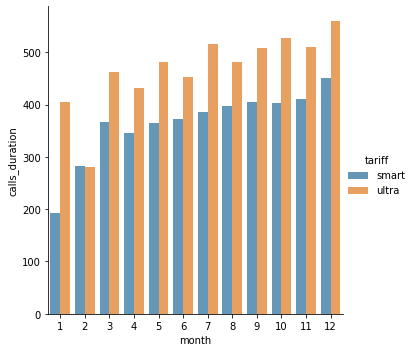

In [36]:
g = sns.catplot(x="month", y="calls_duration", hue="tariff", kind="bar", alpha=0.75, data=df_by_tariff_and_month)

- Как отмечали раньше, пользователи тарифа Ultra общаются больше: им требуется в среднем 500 минут в месяц
- В то время как пользователи тарифа Smart проговоривают примерно 400 минут

### 3.3. Количество сообщений пользователей каждого тарифа в месяц

In [37]:
df_messages = df.pivot_table(index='tariff', values='message_count', aggfunc=['mean', 'median'])
df_messages.columns = ['mean', 'median']
df_messages = df_messages.reset_index()

df_messages.loc[0,'variance'] = np.var(df_smart['message_count'])
df_messages.loc[1,'variance'] = np.var(df_ultra['message_count'])
df_messages['std'] = np.sqrt(df_messages['variance'])

df_messages

,tariff,mean,median,variance,std
0,smart,33.384029,28.0,23.874425,4.886146
1,ultra,49.363452,38.0,139.144489,11.795952


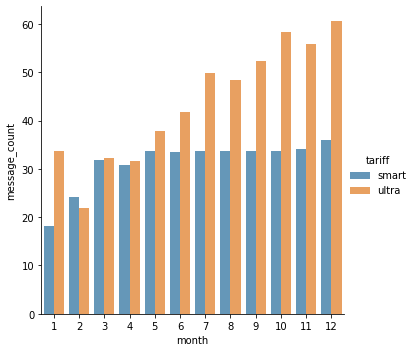

In [38]:
g = sns.catplot(x="month", y="message_count", hue="tariff", kind="bar", alpha=0.75, data=df_by_tariff_and_month)

- Практически одинаковое количество сообщений отправляются абонентам Smart в течение когда — 1 сообщение в день, итого 30
- Количество соощбений, отправляем пользователями тарифа Ultra повышается в течение года, в среднем 45 сообщений в месяц
- Стоит отметить, что у них больше разброс данных: матеметическое ожидание Ultra выше почти в 2 раза 

### 3.3. Объем интернет-трафика пользователей каждого тарифа в месяц

In [39]:
df_internet = df.pivot_table(index='tariff', values='mb_used', aggfunc=['mean', 'median'])
df_internet.columns = ['mean', 'median']
df_internet = df_internet.reset_index()

df_internet.loc[0,'variance'] = np.var(df_smart['mb_used'])
df_internet.loc[1,'variance'] = np.var(df_ultra['mb_used'])
df_internet['std'] = np.sqrt(df_internet['variance'])

df_internet

,tariff,mean,median,variance,std
0,smart,16208.386990,16506.84,6.540711e+06,2557.481423
1,ultra,19468.805208,19308.01,8.172764e+06,2858.804567


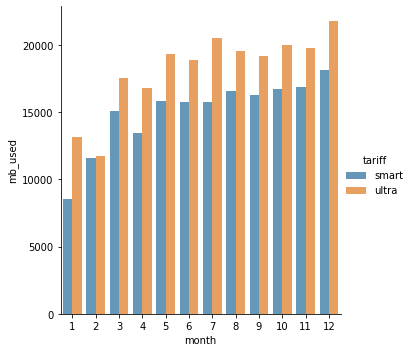

In [40]:
g = sns.catplot(x="month", y="mb_used", hue="tariff", kind="bar", alpha=0.75, data=df_by_tariff_and_month)

15 гигов требуется владельцам Smart и примерно 20 гигабайт абонентам Ultra

## Шаг 4. Проверка гипотез

### 4.1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [60]:
df_revenue = df.pivot_table(index=['user_id', 'tariff'], values = 'monthly_revenue', aggfunc='mean')

df_revenue_smart = df_revenue.query('tariff == "smart"').reset_index()
df_revenue_smart = df_revenue_smart[['monthly_revenue']]

df_revenue_ultra = df_revenue.query('tariff == "ultra"').reset_index()
df_revenue_ultra = df_revenue_ultra[['monthly_revenue']]

df_revenue_ultra.sample(5)

,monthly_revenue
29,1950.0
22,1950.0
24,1950.0
106,1950.0
84,1950.0


In [64]:
#H0 — средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается;
#H1 — средняя выручка различается;

alpha = .05
results = st.ttest_ind(df_revenue_smart, df_revenue_ultra)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: [1.95161433e-49]
Отвергаем нулевую гипотезу


In [63]:
print('Средняя выручка пользователей Smart составила', int(df_revenue_smart['monthly_revenue'].mean()), 'руб')  
print('Средняя выручка пользователей Ultra составила', int(df_revenue_ultra['monthly_revenue'].mean()), 'руб')  

Средняя выручка пользователей Smart составила 1243 руб
Средняя выручка пользователей Ultra составила 2078 руб


- Нулевая гипотеза формулировались исходя из мысли, что выручка пользователей обоих тарифов равна, альтернативная же ее отвергала
- Полученное значение p-value говорит о том, что вероятность того, что выручки тарифов равны стремится к нулю

### 4.2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [69]:
df_w_city = df_revenue.merge(users[['user_id', 'city']], on='user_id', how='left')
df_by_city = df_w_city[['monthly_revenue', 'city']]

df_revenue_moscow = df_by_city.query('city == "Москва"').reset_index()
df_revenue_moscow = df_revenue_moscow[['monthly_revenue']] #99

df_revenue_other = df_by_city.query('city != "Москва"').reset_index()
df_revenue_other = df_revenue_other[['monthly_revenue']] #399

df_revenue_other.count()

monthly_revenue    399
dtype: int64

In [70]:
#H0 — средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов; 
#H1 — средняя выручка различается

alpha = .05
results = st.ttest_ind(df_revenue_moscow, df_revenue_other, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: [0.38490818]
Не получилось отвергнуть нулевую гипотезу


In [71]:
print('Выручка пользователей из Москвы составила', int(df_revenue_moscow['monthly_revenue'].mean()), 'руб')  
print('Выручка пользователей из других городов составила', int(df_revenue_other['monthly_revenue'].mean()), 'руб') 

Выручка пользователей из Москвы составила 1443 руб
Выручка пользователей из других городов составила 1503 руб


- Нулевая гипотеза формулировалась по той же логике, что и первая, то есть в ней утверждалось, что разницы между выруками пользователей из Москвы и других городов нет
- Результат показал, что высока вероятность нулевой гипотезы, то есть можно уверенно предположить, что выручка пользователей из Москвы и других городов практически равны

## Шаг 5. Общий вывод

Были проанализированы порядка 200 тыс записей пользователей мобильного оператора "Мегалайн". 

Пользователи тарифа Ultra, возможно, экстраверты или у них корпоративные номера, потому что они больше разговаривают (в среднем 500 минут в месяц), отправляют больше сообщений (примерно 1 сообщение в день) и дольше проводят времени в интернете (20 гигабайт ). В Декабре пользователи обоих тарифов становятся более активными.

При этом пользователи тарифа Smart не отстают и проговоривают примерно 400 минут, отправляют почти такое же количетсво сообщений и 15 гигов требуется им для интернета.

Проверили 2 гипотезы, проверил которые пришли к следующим выводам:
- Есть разница между средней выручкой пользователей тарифов Smart (1 243 руб) и Ultra (2 078 руб)
- Средняя выручка пользователей не сильно зависит от гео, так как средняя выручка пользователей из Москвы и регионов практически равна (1 443 руб и 1 503 руб)

Компании "Мегалайн" стоит дальше развивать тариф Ultra как в регионах, так и в Москве.